# Project 14 : 한국어 데이터로  챗봇 만들기



* 트랜스포머의 인코더 디코더 구조 이해하기
* 내부 단어 토크나이저 사용하기
* 셀프 어텐션 이해하기
* 한국어에 적용하기

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 수집하기
---

* 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

In [2]:
# 필요한 패키지 임포트
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
print("슝=3")

슝=3


In [3]:
chatbot_file_path=os.getenv('HOME') + '/aiffel/transformer_chatbot/data/Chatbot_data/ChatbotData.csv'
chatbot_data = pd.read_csv(chatbot_file_path)
chatbot_data


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


## Step 2. 데이터 전처리하기
---

* 정규표현식을 사용하여 구두점을 제거하여 단어를 토크나이징(tokenizing)하는 일에 방해가 되지 않도록 정제하는 것을 목표로 합니다.

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [6]:
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
        
    return inputs, outputs

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(chatbot_data['Q'], chatbot_data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기
### 병렬 데이터 전처리
* 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용합니다.

1. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 합니다.

2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가합니다.

3. 최대길이 MAX_LENGTH인 40을 넘는 문장을 필터링합니다.

4. MAX_LENGTH 보다 길이가 짧은 문장들은 40에 맞도록 패딩해줍니다.


In [9]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [14]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [15]:
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [47]:
VOCAB_SIZE = tokenizer.vocab_size + 2
VOCAB_SIZE

8175

#### 정수 인코딩 해보기, 패딩
* 각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩 된 결과를 확인합니다. 그리고 문장의 최대길이를 40으로 정하고, 해당 길이로 Padding 합니다. 

In [17]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [18]:
# Max_Length 설정
MAX_LENGTH = 40

In [19]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [20]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 샘플 개수: 11823
필터링 후의 샘플 개수: 11823


### 포지셔널 인코딩

In [21]:
# 포지셔널 행렬을 구현
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


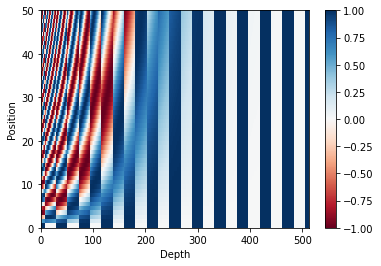

In [22]:
# 행의 크기가 50, 열의 크기가 512인 행렬
# 최대 문장의 길이가 50이고 임베딩 차원을 512로 하는 모델의 입력벡터 모양
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Step 4. 모델 구성하기
---

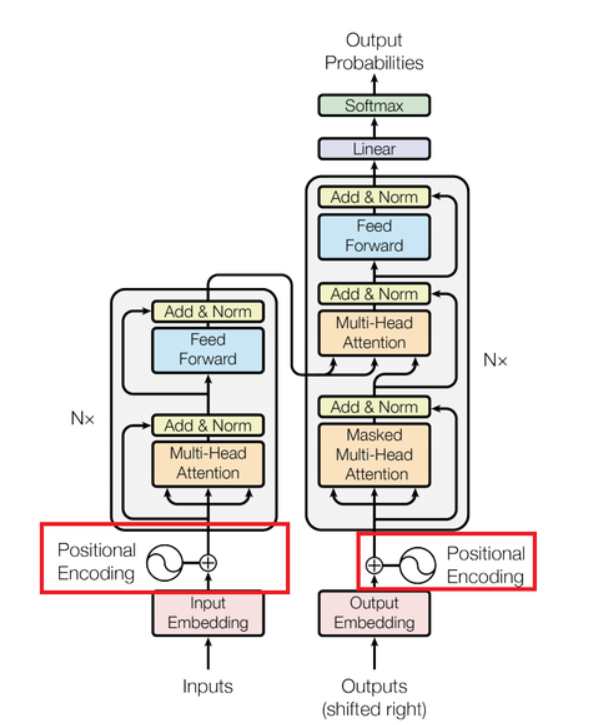

* 포지셔널 인코딩

#### Attention이란?

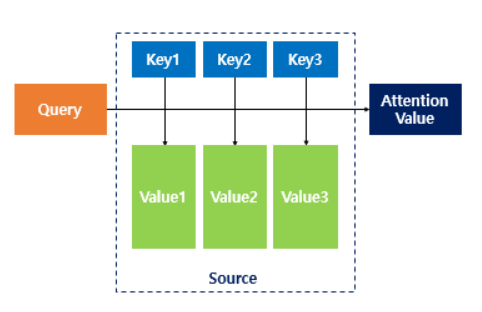

* 주어진 쿼리(Query)에 대해서 모든 키(Key)와의 유사도를 각각 구합니다. 
* 구해닌 이 유사도를 키(Key)와 맵핑되어 있는 각각의 값(Value)에 반영해줍니다. 
* 유사도가 반영된 값(Value)을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션값(Attention Value)라고 합니다. 

#### Transformer에서 사용된 Attention

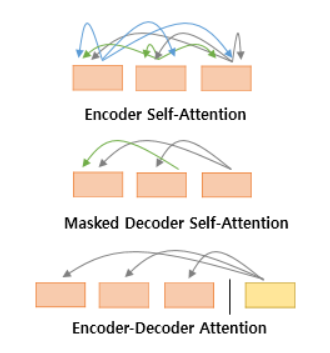

1. 첫번째 그림인 인코더 셀프 어텐션은 인코더에서 이루어지고
2. 두번째 그림인 디코더 셀프 어텐션은 디코더에서 이루어지며
3. 세번째 그림인 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.

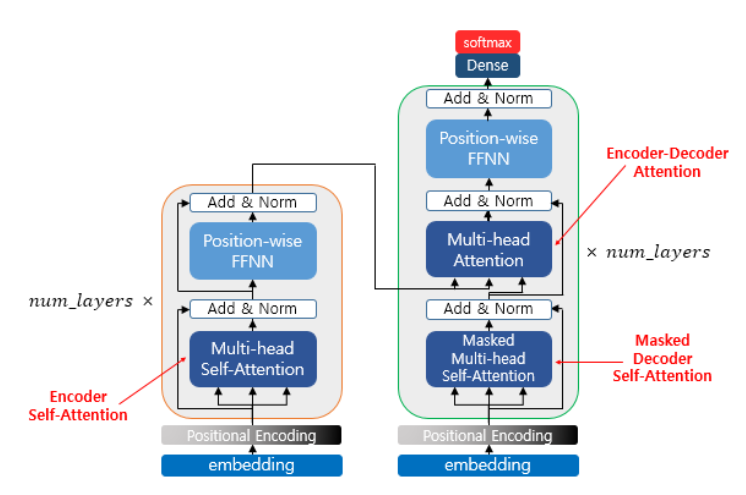
<트랜스 포머 구조에서 각 어텐션이 위치한 곳>

* 트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value)는 기본적으로 '단어(정보를 함축한) 벡터'입니다.
* 여기서 '단어벡터'는 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어벡터 입니다.


##### 세가지 어텐션이 하는 일
* 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* 인코더-디코더 어텐션 : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다. 

##### Self Attention
* 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우

##### Scaled dot product Attention

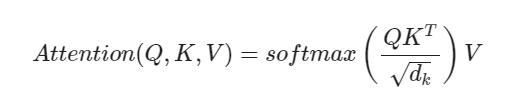

* 어텐션 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구합니다. 
* 구해낸 이 유사도를 키와 맵핑되어있는 각각의 값에 반영해 줍니다.
* 유사도가 반영된 값 을 모두 더해서 뭉쳐주면 최종결과인 어텐션값(Attention Value)라고 합니다.

1. Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
2. 벡터의 내적(dot product)은 벡터의 유사도를 의미한다.
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 Scaling을 위함이다.

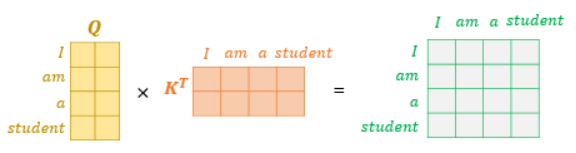

각 단어 벡터의 유사도가 모두 기록된 유사도 행렬!

---
* 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize 해주기 위해서 소프트맥스 함수를 사용합니다.
* 여기에 문장 행렬 V와 곱하면 어텐션값(Attention Value)를 얻습니다.

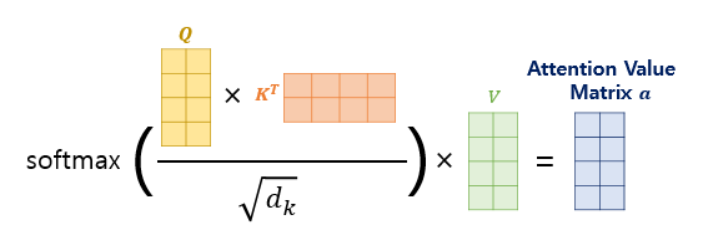

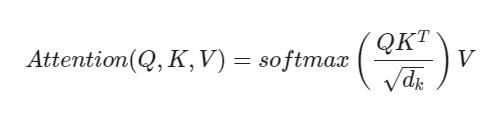
* scled dot product attention

In [12]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


### 멀티 헤드 어텐션 구현하기


In [13]:
# 모델 구현하기
# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출합니다.
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


### 패딩 마스킹(Padding Masking)

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


### 룩어헤드 마스킹

In [25]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


### 인코더

* 인코더 층 만들기

In [26]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


* 인코더 층을 쌓아 인코더 만들기

In [27]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 디코더

In [28]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 디코더 층을 쌓아 디코더 만들기

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 모델 정의 및 학습하기

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


#### (1) 모델 생성
---
* num_layers, d-model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터입니다.

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### (2) 손실함수
---
레이블인 sequence에 padding이 되어있으므로, loss를 계산할때 패딩마스크를 적용합니다.

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


#### (3) 커스텀된 학습률(Learning Rate)
---
모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어가면서 안정적으로 수렴하게 하는 고급기법이 널리 사용됩니다. 이 기법을 Custom Learning rate Scheduling이라고 합니다.

다음 공식으로 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다.

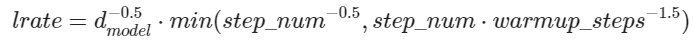

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

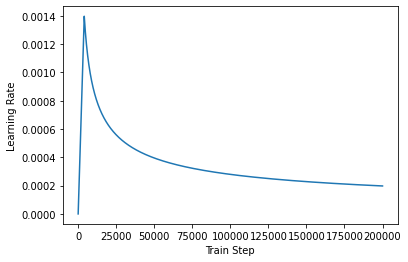

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

learning rate가 초기에는 증가하다가 이후로 감소하는 모습을 보입니다. 그 이유는 커스텀 학습률 스케줄링에서 step_num^(-0.5)에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 선택하기 때문입니다. (위 공식 참조)

#### (4) 모델 컴파일
---

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


#### (5) 훈련하기
---

In [38]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 29s 55ms/step - loss: 1.4460 - accuracy: 0.0270
Epoch 2/50
185/185 [==============================] - 10s 54ms/step - loss: 1.1782 - accuracy: 0.0494
Epoch 3/50
185/185 [==============================] - 10s 55ms/step - loss: 1.0067 - accuracy: 0.0505
Epoch 4/50
185/185 [==============================] - 10s 54ms/step - loss: 0.9282 - accuracy: 0.0545
Epoch 5/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8692 - accuracy: 0.0576
Epoch 6/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8088 - accuracy: 0.0619
Epoch 7/50
185/185 [==============================] - 10s 54ms/step - loss: 0.7426 - accuracy: 0.0682
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.6705 - accuracy: 0.0759
Epoch 9/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5917 - accuracy: 0.0844
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.509

## Step 5. 모델 평가하기
---

#### 챗봇 테스트 하기

* 예측 단계(Inference)는 다음과 같은 과정을 거칩니다. 

1. 새로운 입력 문장에 대해서는 훈련때와 동일한 전처리를 거칩니다.
2. 입력문장을 Tokenizing 하고, START_TOKEN과 END_TOKEN을 추가합니다.
3. 패딩 마스킹과 룩어헤드 마스킹을 계산합니다.
4. 디코더는 입력 sequence로부터 다음 단어를 예측합니다.
5. 디코더는 예측된 다음단어를 기존의 입력 sequence에 추가하여 새로운 입력으로 사용합니다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춥니다.


1~6 까지의 과정을 담은 decoder_inference()함수를 만듭니다!

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [42]:
sentence_generation("가족들 보고 싶어")

입력 : 가족들 보고 싶어
출력 : 저도요 .


'저도요 .'

In [43]:
sentence_generation("나 보이스피싱 당한 거 같은데 어떡해?")

입력 : 나 보이스피싱 당한 거 같은데 어떡해?
출력 : 경찰에 신고하고 취할 수 있는 조취를 취해보세요 .


'경찰에 신고하고 취할 수 있는 조취를 취해보세요 .'

In [44]:
sentence_generation("나도 이제 아재인가")

입력 : 나도 이제 아재인가
출력 : 고민하고 있으면 그럴 거예요 .


'고민하고 있으면 그럴 거예요 .'

In [45]:
sentence_generation("배고파")

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [46]:
sentence_generation("졸려")

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

## 회고
---
* 최근 ChatGPT4 도 나오고, 학부연구생을 할 때부터 공부했었던 Transformer에 대해 구현해보니 이해가 더 깊어진 것 같습니다. Transformer는 자연어 처리 분야뿐만 아니라 Vision Transformer 로도 많이 사용된다고 하니 더 공부해보고 싶습니다. 
* 한국어데이터로는 처음 실행해봤는데 영어나 스페인어 같은 다른나라 언어와는 다르게 한 글자에 여러개의 자음과 모음이 들어가기 때문에 Preprocessing 과정에서 자음모음 글자와 일부 특수문자를 제외하고 공백으로 대체하는 과정이 별도로 필요하지 않았고 제거해주어야 했습니다. SubwordTextEncoder를 토크나이저로 사용하여 병렬 데이터를 구축하는 방법에 대해서도 학습하였습니다.
* 50 epoch 정도 학습하였는데 모델 학습이 잘 이루어진 것 같습니다. 한국어 문장으로 물어봤을 때 때로는 따뜻하고 때로는 현실적인(?) 답변을 잘 해준 것 같습니다. 


